Lambda School Data Science

*Unit 4, Sprint 3, Module 1*

---


# Recurrent Neural Networks (RNNs) and Long Short Term Memory (LSTM) (Prepare)

<img src="https://media.giphy.com/media/l2JJu8U8SoHhQEnoQ/giphy.gif" width=480 height=356>
<br></br>
<br></br>

## Learning Objectives
- <a href="#p1">Part 1: </a>Describe Neural Networks used for modeling sequences
- <a href="#p2">Part 2: </a>Apply a LSTM to a text generation problem using Keras

## Overview

> "Yesterday's just a memory - tomorrow is never what it's supposed to be." -- Bob Dylan

Wish you could save [Time In A Bottle](https://www.youtube.com/watch?v=AnWWj6xOleY)? With statistics you can do the next best thing - understand how data varies over time (or any sequential order), and use the order/time dimension predictively.

A sequence is just any enumerated collection - order counts, and repetition is allowed. Python lists are a good elemental example - `[1, 2, 2, -1]` is a valid list, and is different from `[1, 2, -1, 2]`. The data structures we tend to use (e.g. NumPy arrays) are often built on this fundamental structure.

A time series is data where you have not just the order but some actual continuous marker for where they lie "in time" - this could be a date, a timestamp, [Unix time](https://en.wikipedia.org/wiki/Unix_time), or something else. All time series are also sequences, and for some techniques you may just consider their order and not "how far apart" the entries are (if you have particularly consistent data collected at regular intervals it may not matter).

# Neural Networks for Sequences (Learn)

## Overview

There's plenty more to "traditional" time series, but the latest and greatest technique for sequence data is recurrent neural networks. A recurrence relation in math is an equation that uses recursion to define a sequence - a famous example is the Fibonacci numbers:

$F_n = F_{n-1} + F_{n-2}$

For formal math you also need a base case $F_0=1, F_1=1$, and then the rest builds from there. But for neural networks what we're really talking about are loops:

![Recurrent neural network](https://upload.wikimedia.org/wikipedia/commons/b/b5/Recurrent_neural_network_unfold.svg)

The hidden layers have edges (output) going back to their own input - this loop means that for any time `t` the training is at least partly based on the output from time `t-1`. The entire network is being represented on the left, and you can unfold the network explicitly to see how it behaves at any given `t`.

Different units can have this "loop", but a particularly successful one is the long short-term memory unit (LSTM):

![Long short-term memory unit](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Long_Short-Term_Memory.svg/1024px-Long_Short-Term_Memory.svg.png)

There's a lot going on here - in a nutshell, the calculus still works out and backpropagation can still be implemented. The advantage (ane namesake) of LSTM is that it can generally put more weight on recent (short-term) events while not completely losing older (long-term) information.

After enough iterations, a typical neural network will start calculating prior gradients that are so small they effectively become zero - this is the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), and is what RNN with LSTM addresses. Pay special attention to the $c_t$ parameters and how they pass through the unit to get an intuition for how this problem is solved.

So why are these cool? One particularly compelling application is actually not time series but language modeling - language is inherently ordered data (letters/words go one after another, and the order *matters*). [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) is a famous and worth reading blog post on this topic.

For our purposes, let's use TensorFlow and Keras to train RNNs with natural language. Resources:

- https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py
- https://keras.io/layers/recurrent/#lstm
- http://adventuresinmachinelearning.com/keras-lstm-tutorial/

Note that `tensorflow.contrib` [also has an implementation of RNN/LSTM](https://www.tensorflow.org/tutorials/sequences/recurrent).

## Follow Along

Sequences come in many shapes and forms from stock prices to text. We'll focus on text, because modeling text as a sequence is a strength of Neural Networks. Let's start with a simple classification task using a TensorFlow tutorial. 

### RNN/LSTM Sentiment Classification with Keras

In [0]:
'''
#Trains an LSTM model on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
**Notes**
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


In [0]:
x_train[0][-81:]

array([   15,   256,     4,     2,     7,  3766,     5,   723,    36,
          71,    43,   530,   476,    26,   400,   317,    46,     7,
           4, 12118,  1029,    13,   104,    88,     4,   381,    15,
         297,    98,    32,  2071,    56,    26,   141,     6,   194,
        7486,    18,     4,   226,    22,    21,   134,   476,    26,
         480,     5,   144,    30,  5535,    18,    51,    36,    28,
         224,    92,    25,   104,     4,   226,    65,    16,    38,
        1334,    88,    12,    16,   283,     5,    16,  4472,   113,
         103,    32,    15,    16,  5345,    19,   178,    32],
      dtype=int32)

In [0]:
print('Pad Sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

Pad Sequences (samples x time)
x_train shape:  (25000, 80)
x_test shape:  (25000, 80)


In [0]:
x_train[0]

array([   15,   256,     4,     2,     7,  3766,     5,   723,    36,
          71,    43,   530,   476,    26,   400,   317,    46,     7,
           4, 12118,  1029,    13,   104,    88,     4,   381,    15,
         297,    98,    32,  2071,    56,    26,   141,     6,   194,
        7486,    18,     4,   226,    22,    21,   134,   476,    26,
         480,     5,   144,    30,  5535,    18,    51,    36,    28,
         224,    92,    25,   104,     4,   226,    65,    16,    38,
        1334,    88,    12,    16,   283,     5,    16,  4472,   113,
         103,    32,    15,    16,  5345,    19,   178,    32],
      dtype=int32)

In [0]:
model = Sequential()

"""
activation == tanh
recurrent_activation == sigmoid
recurrent_dropout == 0
unroll is False
use_bias is True
"""

from tensorflow.keras.regularizers import l2

model.add(Embedding(max_features, 128))
model.add(LSTM(32, dropout=0.2, activation='tanh',
               recurrent_constraint=
                recurrent_dropout=0, unroll=False, use_bias=True))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          640000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 648,353
Trainable params: 648,353
Non-trainable params: 0
_________________________________________________________________


In [0]:
unicorns = model.fit(x_train, y_train,
          batch_size=1024, 
          epochs=10, 
          validation_data=(x_test,y_test))

Epoch 1/10


ValueError: ignored

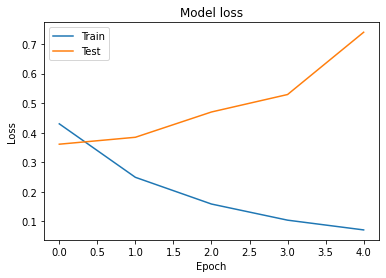

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(unicorns.history['loss'])
plt.plot(unicorns.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show();

## Challenge

You will be expected to use an Keras LSTM for a classicification task on the *Sprint Challenge*. 

# LSTM Text generation with Keras (Learn)

## Overview

What else can we do with LSTMs? Since we're analyzing the *sequence*, we can do more than classify - we can *generate* text. I'ved pulled some news stories using [newspaper](https://github.com/codelucas/newspaper/).

This example is drawn from the Keras [documentation](https://keras.io/examples/lstm_text_generation/).

In [0]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import RMSprop

import numpy as np
import random
import sys
import os

In [0]:
data_files = os.listdir('./articles')

FileNotFoundError: ignored

In [0]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/master/module1-rnn-and-lstm/wp_articles.json"
data = pd.read_json(url)

In [0]:
data.shape

(136, 1)

In [0]:
data.head()

,article
0,Contributing columnist\n\nThe House is on fire...
1,When President Trump announced his decision to...
10,Russian President Vladimir Putin speaks at a s...
100,“The Queen’s Speech” is designed to acknowledg...
101,"Like an aging rock star, the president is now ..."


In [0]:
data = data['article'].tolist()

In [0]:
data[-1]

['The threat to hard-won women’s rights in Rojava is receiving little coverage in the context of Turkey’s military campaign, but women there say Turkish aggression could wipe out these reforms and perhaps herald a return to the misogyny and sexual violence of militant Islamism. There is widespread concern about the possible escape of ISIS prisoners held by Kurdish forces, and on Sunday, it was reported that at least 750 people suspected of affiliation with ISIS fled a secure displacement camp in the chaos caused by Turkish shelling. In addition, several dozen “high-value” ISIS prisoners were reportedly left behind by U.S. troops when they retreated, the New York Times reported, and ISIS has already claimed at least two attacks in the area since the invasion started, including a car bombing that killed three people.']

str

In [0]:
# Encode Data as Chars

# Gather all text 
# Why? 1. See all possible characters 2. For training / splitting later
text = " ".join(data)

# Unique Characters
chars = list(set(text))

# Lookup Tables
char_int = {c:i for i, c in enumerate(chars)} 
int_char = {i:c for i, c in enumerate(chars)} 

In [0]:
len(chars)

121

In [0]:
# Create the sequence data

maxlen = 40
step = 5

encoded = [char_int[c] for c in text]

sequences = [] # Each element is 40 chars long
next_char = [] # One element for each sequence

for i in range(0, len(encoded) - maxlen, step):
    
    sequences.append(encoded[i : i + maxlen])
    next_char.append(encoded[i + maxlen])
    
print('sequences: ', len(sequences))

sequences:  178374


In [0]:
print("Hello Griffin \n this is a sample")

Hello Griffin 
 this is a sample


In [0]:
sequences[0]

[9,
 58,
 56,
 6,
 54,
 31,
 5,
 3,
 6,
 31,
 56,
 78,
 26,
 101,
 58,
 39,
 3,
 35,
 56,
 31,
 29,
 6,
 18,
 18,
 106,
 52,
 23,
 26,
 13,
 58,
 3,
 29,
 23,
 26,
 31,
 29,
 26,
 58,
 56,
 26]

In [0]:
# Create x & y

x = np.zeros((len(sequences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sequences),len(chars)), dtype=np.bool)

for i, sequence in enumerate(sequences):
    for t, char in enumerate(sequence):
        x[i,t,char] = 1
        
    y[i, next_char[i]] = 1
        

In [0]:
x.shape

(178374, 40, 121)

In [0]:
print(x[0][0])
print(sequences[0][0])

[False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False]
9


In [0]:
int_char[9]

'C'

In [0]:
y.shape

(178374, 121)

In [0]:
# build the model: a single LSTM

model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
def sample(preds):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / 1
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [0]:
def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    
    start_index = random.randint(0, len(text) - maxlen - 1)
    
    generated = ''
    
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)
    
    for i in range(400):
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_int[char]] = 1
            
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds)
        next_char = int_char[next_index]
        
        sentence = sentence[1:] + next_char
        
        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()


print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [0]:
# fit the model

model.fit(x, y,
          batch_size=32,
          epochs=10,
          callbacks=[print_callback])

Epoch 1/10
5573/5575 [============================>.] - ETA: 0s - loss: 2.5643
----- Generating text after Epoch: 0
----- Generating with seed: "ncompromising,” and kept the film “from "
ncompromising,” and kept the film “from ness tte andedto F-Rsaceons B5 tare veming lares ved junt the copnory to ranusishes no sattiviss.”

Ans, on por wab ter tome has beot’s )an Cur cading,, “ustedint sedadtor la cronbo, the 9ut hifk Svestimerdely A tiont of Sinwtring’s stourist ated byen oul the uncs hampenviduld. at begellon ssersing” tor vistion ”eCs on iede mowe,) Rilingalingty capr:

Hepsmoovers the homnasise Sevoty Ths fores in 
5575/5575 [==============================] - 88s 16ms/step - loss: 2.5643
Epoch 2/10
5572/5575 [============================>.] - ETA: 0s - loss: 2.2056
----- Generating text after Epoch: 1
----- Generating with seed: "commentator Ana Navarro-Cárdenas wrote, "
commentator Ana Navarro-Cárdenas wrote, purskels's on wor A,kys recurding a way silais, crmilfs as inloes to wa

## Challenge

You will be expected to use a Keras LSTM to generate text on today's assignment. 

# Review

- <a href="#p1">Part 1: </a>Describe Neural Networks used for modeling sequences
    * Sequence Problems:
        - Time Series (like Stock Prices, Weather, etc.)
        - Text Classification
        - Text Generation
        - And many more! :D
    * LSTMs are generally preferred over RNNs for most problems
    * LSTMs are typically a single hidden layer of LSTM type; although, other architectures are possible.
    * Keras has LSTMs/RNN layer types implemented nicely
- <a href="#p2">Part 2: </a>Apply a LSTM to a text generation problem using Keras
    * Shape of input data is very important
    * Can take a while to train
    * You can use it to write movie scripts. :P 